# Fundamentals of Data Analysis, Winter 21/22
- Author: Brendan Tunney
- ID - G00270683

## Importing the CAO data


In [1]:
#Importing libraries

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re # regular expressions {1}
import requests as rq #{1} # To retrieve HTTP Data
import urllib.request as urlrq # Importing pythons URL module
import csv # importing csv module to read, write csv
from unicodedata import normalize # Imported to use normalised string values.
# Dates and times.
import datetime as dt # Importing date/time module


### 2021 Points

In [2]:
resp = rq.get('http://www2.cao.ie/points/l8.php') # Getting CAO points data for 2021

resp # checking response. 200 = succesful

<Response [200]>

In [3]:
now = dt.datetime.now() # Get the current date and time.

nowstr = now.strftime('%Y%m%d_%H%M%S') # # Format date and time as a string.

pathhtml = 'resp_' + nowstr + '.html' # Creating file path

In [4]:
# If we decode per server as ISO-8859-1, it will be noted that one line uses \x96 - not defined in ISO-8859-1. CP1252 is used instead.

original_encoding = resp.encoding

resp.encoding = 'cp1252'


In [5]:
re_course = re.compile(r'([A-Z]{2}[0-9]{3})(.*)') # Compile the reg. expressions.

In [6]:
with open(pathhtml, 'w') as f:
    f.write(resp.text)

In [7]:
path2021 = 'df2021'  + '.csv'

In [8]:
no_lines = 0 # Counting # of lines processed

with open(path2021, 'w') as f:                                            # Open csv file to write
   
    f.write(','.join(['code', 'title', 'pointsR1', 'pointsR2']) + '\n')   # Write file header
    for line in resp.iter_lines():                                        # Loop thorugh lines of response data
        dline = line.decode('cp1252')                                     # Decode line
        if re_course.fullmatch(dline):                                    # Match only lines with a course
            no_lines = no_lines + 1                                       # If matched,add '1' to the counter
            course_code = dline[:5]                                       # Course code (5 characters)
            course_title = dline[7:57].strip()                            # Course title and stripping out blanks
            course_points = re.split(' +', dline[60:])                    # First round points accounting for spaces
            if len(course_points) != 2:                                   # Second round points - if applicable.
                course_points = course_points[:2]
            linesplit = [course_code, course_title, course_points[0], course_points[1]] # Creating header array.
            f.write(','.join(linesplit) + '\n')                           # Rejoining split values with comma seperation and adding new line for each course

print(f"Total number of lines is {no_lines}.")                            # Number of processed lines

Total number of lines is 949.


In [9]:
df2021 = pd.read_csv(path2021, encoding='cp1252')

### 2020 Points

In [10]:
url = 'http://www2.cao.ie/points/CAOPointsCharts2020.xlsx' # URL for 2020 points
    
df2020 = pd.read_excel(url, skiprows = 10)                 # read in excel file, skipping first 10 rows that do not contain course data    

# Renaming columns to match 2021 file

df2020.rename(columns={"COURSE CODE2": "code", "R1 POINTS": "pointsR1", "R2 POINTS": "pointsR2", "COURSE TITLE": "title"}, inplace=True)

new_col_order = ['code', 'title', 'pointsR1', 'pointsR2', 'EOS','LEVEL']   # New column order list
df2020 = df2020.reindex(columns = new_col_order)                     # Re-ordering columns

df2020 = df2020.loc[df2020.loc[:, 'LEVEL'] == 8]                     # Added to filter for just level 8 - matching current data for 2021 & 2019

df2020.set_index('code', inplace=True)                               # set idex column to ''code''



In [11]:
data2020 = 'df2020' + '.csv' # Filepath for df

In [12]:
df2020.to_csv(data2020) # saving df

### 2019 Points

In [13]:
import tabula # importing tabula module for pdf read

In [14]:
url = 'http://www2.cao.ie/points/lvl8_19.pdf'

#df2019 = tabula.read_pdf(url, pages = "all") # reading in table, important to specify pages = "all" or you will only read 1

tabula.convert_into(url, "df2019.csv", output_format="csv", pages='all') # Using tabula module to convert to csv

In [15]:
df2019 = pd.read_csv('df2019.csv', sep=',')
df2019.dropna(                         # Using drop function to remove blank (NaN lines)
    axis=0,                            # "0" = Row. "1" = Column
    how='any',                         # "Any" will remove a row with just a single blank cell
    thresh=None,                       # Can be used to set a 'threshold' of how many empty cells are tolerated
    subset=None,                       # Set the array to be considered, none defaults to all
    inplace=True                       # Must be set to "true" to allow changes to be made
 )

df2019.rename(columns={"Course Code": "code","INSTITUTION and COURSE":"title"}, inplace =True)

df2019.set_index('code', inplace=True) # set idex column to ''code''

data2019 = 'df2019' + '.csv'
df2019.to_csv(data2019) # creating new df

### CAO Comparison

Merging Data for comparison

In [16]:
data2021 = pd.read_csv('df2021.csv')
data2020 = pd.read_csv('df2020.csv')
data2019 = pd.read_csv('df2019.csv')

Joining 2021 & 2020 datasets

In [76]:

data21_20 = data2021.merge(data2020, on='code') # merging 2021 & 2020 df based on 'code'
data21_20 = data21_20.drop(['title_y','EOS','LEVEL','pointsR2_x', 'pointsR2_y'], axis=1) #removing column to do comparison between round 1 points
data21_20.rename(columns={"title_x": "Title","pointsR1_x":"Points_21", "pointsR1_y":"Points_20"}, inplace =True)

columns = ['Points_21', 'Points_20'] # To replace the str values (#matric) with NaN
data21_20[columns] = data21_20[columns].apply(pd.to_numeric, errors='coerce', axis=1)

data21_20.dropna(axis=0, how='any', thresh=None,subset=None, inplace=True) # Using drop function to remove 'NaN' values

data21_20.to_csv("df21_20.csv", index=False)

Joining 2020 & 2021 datasets

In [18]:
data20_19 = data2020.merge(data2019, on='code')
data20_19 = data20_19.drop(['pointsR1', 'pointsR2', 'LEVEL', 'title_y', 'Mid'], axis=1) # removing columns to compare EOS points
data20_19.rename(columns={"title_x": "Title","EOS_x": "EOS_20", "EOS_y":"EOS_19"}, inplace=True) # reaming columns.dropna(inplace=True)
data20_19.to_csv("df20_19.csv", index=False) #saving csv

In [23]:
import seaborn as sns                  #Importing seaborn for plotting
data21_20 = pd.read_csv('df21_20.csv') # reading in csv file

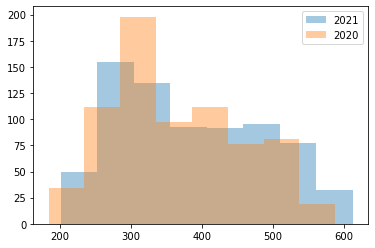

In [99]:
plt.hist(data=data21_20, x = 'Points_21', bins = 8, alpha = 0.4, label = "2021")
plt.hist(data=data21_20, x = 'Points_20', bins =8, alpha = 0.4, label = '2020')
plt.legend()
plt.show()


